In [1]:
import sys
import os
import json
import time
import logging
import networkx as nx

# Now we can import modules from python_fbas
from python_fbas.fbas_graph import FBASGraph
from python_fbas.fbas_graph_analysis import is_fba_resilient_approx, find_disjoint_quorums, find_min_quorum
from python_fbas.constellation.constellation import *
import python_fbas.constellation.config as config

# %load_ext line_profiler

# Create a logger
logger = logging.getLogger("JupyterLogger")

# Remove existing handlers to prevent duplicates
if logger.hasHandlers():
    logger.handlers.clear()

debug_level = logging.INFO

# Add a StreamHandler to send logs to the notebook output
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(debug_level)  # Ensure the handler captures DEBUG logs
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

logger.addHandler(handler)
logger.setLevel(debug_level)

logger.info("Logger is set up and ready to use.")

2025-02-12 06:50:44,820 - INFO - Logger is set up and ready to use.


In [ ]:
# Let's first generate a 16-orgs single-universe regular FBAS
fbas = random_single_universe_regular_fbas(16, 9, 14)
fbas_graph = single_universe_regular_fbas_to_fbas_graph(fbas)
assert not find_disjoint_quorums(fbas_graph)

# then we pick a minimal quorum (slow...)
q = find_min_quorum(fbas_graph)

We have 20 Byzantine nodes
2025-02-12 06:59:45,004 - INFO - Computing constellation for t=1


INFO:JupyterLogger:Computing constellation for t=1


2025-02-12 06:59:45,042 - INFO - Computing constellation for t=2


INFO:JupyterLogger:Computing constellation for t=2


2025-02-12 06:59:45,082 - INFO - Computing constellation for t=3


INFO:JupyterLogger:Computing constellation for t=3


2025-02-12 06:59:45,120 - INFO - Computing constellation for t=4


INFO:JupyterLogger:Computing constellation for t=4


2025-02-12 06:59:45,160 - INFO - Computing constellation for t=5


INFO:JupyterLogger:Computing constellation for t=5


2025-02-12 06:59:45,209 - INFO - Computing constellation for t=6


INFO:JupyterLogger:Computing constellation for t=6


2025-02-12 06:59:45,276 - INFO - Computing constellation for t=7


INFO:JupyterLogger:Computing constellation for t=7


2025-02-12 06:59:45,361 - INFO - Computing constellation for t=8


INFO:JupyterLogger:Computing constellation for t=8


2025-02-12 06:59:45,471 - INFO - Computing constellation for t=9


INFO:JupyterLogger:Computing constellation for t=9


2025-02-12 06:59:45,485 - INFO - Computing constellation for t=10


INFO:JupyterLogger:Computing constellation for t=10


2025-02-12 06:59:45,525 - INFO - Computing constellation for t=11


INFO:JupyterLogger:Computing constellation for t=11


2025-02-12 06:59:45,548 - INFO - Computing constellation for t=12


INFO:JupyterLogger:Computing constellation for t=12


2025-02-12 06:59:45,678 - INFO - Computing constellation for t=13


INFO:JupyterLogger:Computing constellation for t=13


2025-02-12 06:59:45,724 - INFO - Computing constellation for t=14


INFO:JupyterLogger:Computing constellation for t=14


2025-02-12 06:59:45,854 - INFO - Computing constellation for t=15


INFO:JupyterLogger:Computing constellation for t=15


2025-02-12 06:59:45,987 - INFO - Computing constellation for t=16


INFO:JupyterLogger:Computing constellation for t=16


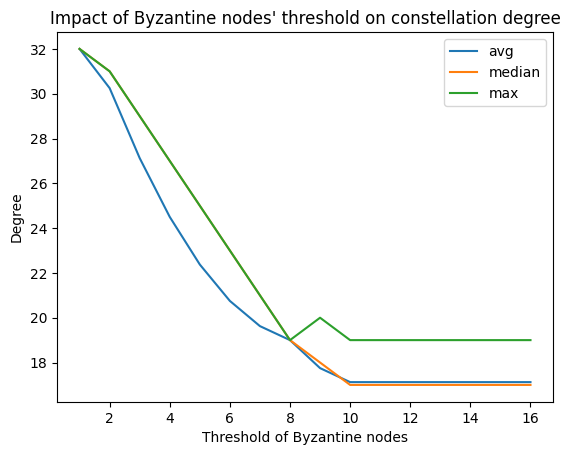

In [10]:
# now we are going to simulate the impact on constellation of byzantine nodes changing their thresholds
# we consider a maximal set of byzantine nodes, i.e. all nodes in the complement of the quorum
from typing import Collection
import statistics


byz_nodes = fbas_graph.validators - set(q)
print(f"We have {len(byz_nodes)} Byzantine nodes")

def set_thresholds(fg:FBASGraph, s:Collection[str], t) -> FBASGraph:
    """
    Set the threshold of each validator in s to t
    """
    assert set(s) <= fg.validators
    for v in s:
        qset = fg.qsets[fg.qset_vertex_of(v)].to_dict()
        qset['threshold'] = t
        fg.update_validator(v, qset)
    return fg

 # for each possible threshold t, we set the threshold of all byzantine nodes to t, compute the constellation overlay, and note its average degree and median degree (along with stddev), and its max degree.
data = {}
for i in range(1, len(fbas.keys()) + 1):
    new_fbas_graph = set_thresholds(fbas_graph, byz_nodes, i)
    new_fbas = fbas_graph_to_single_universe_regular(new_fbas_graph)[0]
    logger.info(f"Computing constellation for t={i}")
    overlay = constellation_overlay(new_fbas)
    degrees = [d for n, d in overlay.degree()]
    data[i] = {
        "avg": sum(degrees) / len(degrees),
        "median": statistics.median(degrees),
        "stddev": statistics.stdev(degrees),
        "max": max(degrees)
    }

# now we plot the results
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
ax.plot(data.keys(), [data[i]["avg"] for i in data.keys()], label="avg")
ax.plot(data.keys(), [data[i]["median"] for i in data.keys()], label="median")
ax.plot(data.keys(), [data[i]["max"] for i in data.keys()], label="max")
ax.set_xlabel("Threshold of Byzantine nodes")
ax.set_ylabel("Degree")
ax.set_title("Impact of Byzantine nodes' threshold on constellation degree")
ax.legend()
plt.show()
